In [7]:
import joblib
import json
import pandas as pd
from shapely.geometry import shape, Point

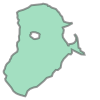

In [5]:
# Load model
model = joblib.load('random_forest_model.pkl')

# Load scalers
X_scaler = joblib.load('X_scaler.pkl')
Y_scaler = joblib.load('Y_scaler.pkl')
with open('ski_areas.geojson', 'r') as f:
    ski_areas = json.load(f)
crystal_mountain_area = [site for site in ski_areas['features'] if site['properties']['name'] == 'Crystal Mountain'][0]
crystal_polygon = shape(crystal_mountain_area['geometry'])
crystal_polygon

In [9]:
!aws s3 cp s3://aimees-snow-project/results.parquet .

download: s3://aimees-snow-project/results.parquet to ./results.parquet


In [10]:
# Load data
results_df = pd.read_parquet('results.parquet')
results_df = results_df.dropna(subset=['fsca'])
results_df['datetime'] = pd.to_datetime(results_df['time'])
results_df['day'] = results_df['datetime'].dt.day
results_df['month'] = results_df['datetime'].dt.month
results_df['year'] = results_df['datetime'].dt.year
results_df.loc[~results_df['fsca'].between(0, 1000), 'fsca'] = None
results_df.head()

,time,longitude,latitude,coastal,blue,green,red,nir08,swir16,swir22,fsca,datetime,day,month,year
0,2024-12-25T18:49:51.253821Z,-121.508679,46.922242,36261.0,35869,34486,34155,33048,17509,18436,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
1,2024-12-25T18:49:51.253821Z,-121.508679,46.921895,36219.0,35757,34552,34083,32874,17493,18473,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
2,2024-12-25T18:49:51.253821Z,-121.508679,46.921547,36237.0,35765,34417,34086,32936,17457,18473,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
3,2024-12-25T18:49:51.253821Z,-121.508679,46.921199,36219.0,35760,34536,34043,32889,17450,18471,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024
4,2024-12-25T18:49:51.253821Z,-121.508331,46.923286,36363.0,35863,34542,34192,33038,17589,18608,NaN,2024-12-25 18:49:51.253821+00:00,25,12,2024


In [11]:
input_columns = ["red", "green", "blue", "coastal", "nir08", "swir16", "swir22", "fsca", "latitude", "longitude", "month"]
x_input_data = results_df[input_columns]
x_scaled = X_scaler.transform(x_input_data)

In [12]:
%%time
y_pred = model.predict(x_scaled)
y_pred

CPU times: user 58.6 s, sys: 3.49 s, total: 1min 2s
Wall time: 1min 2s


array([0.28870968, 0.29087558, 0.2924424 , ..., 0.08354839, 0.08737327,
       0.08737327], shape=(19957490,))

In [13]:
y_scaled = Y_scaler.inverse_transform([[pred] for pred in y_pred])
results_df['snow_depth_prediction'] = y_scaled
results_df.shape

(19957490, 16)

In [19]:
# reduce overlapping pixels: group by day, lat, lon and pick the highest value for that pixel
max_by_day = results_df.groupby(['year', 'month', 'day', 'latitude', 'longitude']).agg({'snow_depth_prediction': 'max'}).reset_index(level=[3,4])
max_by_day.head()

latitude   longitude  snow_depth_prediction
year month day                                              
1982 11    20   46.909031 -121.498596              31.230000
           20   46.909031 -121.498249              32.420000
           20   46.909379 -121.498944              31.590000
           20   46.909379 -121.498596              27.480000
           20   46.909379 -121.498249              35.620001

In [40]:
# make sure that there are pixels that cover the entire polygon for each day
def check_daily_coverage(rows, target_polygon):
    # Create points from your DataFrame
    points = [Point(lon, lat) for lon, lat in zip(rows['longitude'], rows['latitude'])]

    # Check if all points are within the polygon
    points_in_polygon = [point.within(target_polygon) for point in points]
    coverage_percentage = sum(points_in_polygon) / len(points_in_polygon) * 100
    return coverage_percentage

for daily_index in max_by_day.index.unique():
    rows = max_by_day.loc[daily_index]
    coverage_percentage = check_daily_coverage(rows, crystal_polygon)
    if coverage_percentage < 100:
        # print(f"Day {daily_index} has {coverage_percentage}% coverage")
        # remove from group if <99% coverage

Day (1982, 11, 20) has 99.42196531791907% coverage
Day (1982, 12, 13) has 99.42196531791907% coverage
Day (1982, 12, 22) has 99.42196531791907% coverage
Day (1982, 12, 29) has 99.42196531791907% coverage
Day (1983, 1, 30) has 99.42196531791907% coverage
Day (1984, 4, 14) has 99.42196531791907% coverage
Day (1984, 4, 23) has 99.42196531791907% coverage
Day (1984, 5, 25) has 99.42196531791907% coverage
Day (1984, 6, 1) has 99.42196531791907% coverage
Day (1984, 6, 10) has 99.42196531791907% coverage
Day (1984, 6, 26) has 99.42196531791907% coverage
Day (1984, 7, 19) has 99.42196531791907% coverage
Day (1984, 7, 28) has 99.42196531791907% coverage
Day (1984, 8, 4) has 99.42196531791907% coverage
Day (1984, 8, 29) has 99.42196531791907% coverage
Day (1984, 9, 14) has 99.42196531791907% coverage
Day (1984, 9, 30) has 99.42196531791907% coverage
Day (1984, 10, 7) has 99.42196531791907% coverage
Day (1984, 11, 8) has 99.42196531791907% coverage
Day (1984, 11, 24) has 99.42196531791907% covera

KeyboardInterrupt: 

In [ ]:
avg_by_month = max_by_day.groupby(['year', 'month']).agg({'snow_depth_prediction': 'mean'})

In [ ]:
# what we have a matrix of observations, identified by datetime and a snow depth prediction for each pixel.
# We can multiply those by the size of each pixel to get the area of snow.
# Then we can sum those up to get the total area of snow for each year.
area_of_each_pixel = 30 * 30
avg_by_month['snow_volume_prediction'] = avg_by_month['snow_depth_prediction'] * area_of_each_pixel
avg_by_month['snow_volume_prediction']

# aggregate over the season (November through April)
avg_by_month = avg_by_month[avg_by_month['month'].isin(range(11, 5))]
sum_over_season = avg_by_month.groupby('year').agg({'snow_volume_prediction': 'sum'})
sum_over_season.plot(kind='line', x='year', y='snow_volume_prediction')
plt.show()